# 🍏 Fruit & Veg Quality Project

This project uses **TensorFlow Lite** and **Edge Impulse** to classify fruit freshness.

- Supports Raspberry Pi Zero 2W  
- Optimized with EON Compiler  
- Inference time: *5ms*


## Import Libraries

In [1]:
import sys
import os
sys.path.append(os.path.abspath(".."))

import time
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import tflite_runtime.interpreter as tflite

from src.utils import MODEL_PATH, LABELS

# Models

In [2]:
!ls ../models

ei-fruit-detectorv2-classifier-tensorflow-lite-int8-quantized-model.6.lite
ei-fruits-detector-classifier-tensorflow-lite-int8-quantized-model.4.lite


In [3]:
!ls ../images

example1.jpg  example3.jpg  example5.jpg  example7.jpg
example2.jpg  example4.jpg  example6.jpg


## Functions

In [4]:
def image_classification(img_path, apply_softmax=False) -> None:
    """
    Classify an image using a TensorFlow Lite model.
    Args:
        img_path (str): Path to the input image.
        apply_softmax (bool): Whether to apply softmax to the output probabilities.
    Returns:
        None
    """
    # Load the image
    img = Image.open(img_path)
    plt.figure(figsize=(4, 4))
    plt.imshow(img)
    plt.axis('off')

    model_path = MODEL_PATH

    labels = LABELS
    
    top_k_results=3

    # Load the TFLite model
    interpreter = tflite.Interpreter(model_path=model_path)
    interpreter.allocate_tensors()

    # Get input and output tensors
    input_details = interpreter.get_input_details()
    output_details = interpreter.get_output_details()

    # Preprocess
    img = img.resize((input_details[0]['shape'][1], 
                      input_details[0]['shape'][2]))
    
    input_dtype = input_details[0]['dtype']
    
    if input_dtype == np.uint8:
        input_data = np.expand_dims(np.array(img), axis=0)
    elif input_dtype == np.int8:
        scale, zero_point = input_details[0]['quantization']
        img_array = np.array(img, dtype=np.float32) / 255.0
        img_array = (img_array / scale + zero_point).clip(-128, 127).astype(np.int8)
        input_data = np.expand_dims(img_array, axis=0)
    else:  # float32
        input_data = np.expand_dims(np.array(img, dtype=np.float32), axis=0) / 255.0

    # Inference on Raspi-Zero
    start_time = time.time()
    interpreter.set_tensor(input_details[0]['index'], input_data)
    interpreter.invoke()
    end_time = time.time()
    inference_time = (end_time - start_time) * 1000  # Convert to milliseconds

    # Obtain results
    predictions = interpreter.get_tensor(output_details[0]['index'])[0]

    # Get indices of the top k results
    top_k_indices = np.argsort(predictions)[::-1][:top_k_results]

    # Handle output based on type
    output_dtype = output_details[0]['dtype']
    if output_dtype in [np.int8, np.uint8]:
        # Dequantize the output
        scale, zero_point = output_details[0]['quantization']
        predictions = (predictions.astype(np.float32) - zero_point) * scale
    
    if apply_softmax:
        # Apply softmax
        exp_preds = np.exp(predictions - np.max(predictions))
        probabilities = exp_preds / np.sum(exp_preds)
    else:
        probabilities = predictions

    print("\n\t[PREDICTION]        [Prob]\n")
    for i in range(top_k_results):
        print("\t{:20}: {:.1f}%".format(
            labels[top_k_indices[i]],
            probabilities[top_k_indices[i]] * 100))
    print ("\n\tInference time: {:.1f}ms".format(inference_time))

## Testing

/usr/lib/python3/dist-packages/numpy/core/getlimits.py:518: UserWarning: The value of the smallest subnormal for <class 'numpy.float64'> type is zero.
  setattr(self, word, getattr(machar, word).flat[0])
/usr/lib/python3/dist-packages/numpy/core/getlimits.py:89: UserWarning: The value of the smallest subnormal for <class 'numpy.float64'> type is zero.
  return self._float_to_str(self.smallest_subnormal)



	[PREDICTION]        [Prob]

	rotten banana       : 99.6%
	unripe tomato       : 0.0%
	unripe orange       : 0.0%

	Inference time: 15.5ms


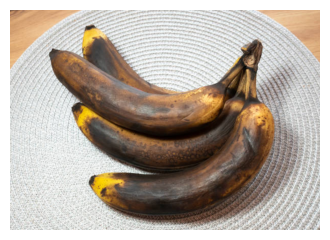

In [5]:
img_path = "../images/example1.jpg"
image_classification(img_path)


	[PREDICTION]        [Prob]

	fresh orange        : 70.7%
	fresh banana        : 28.9%
	rotten apple        : 0.4%

	Inference time: 13.6ms


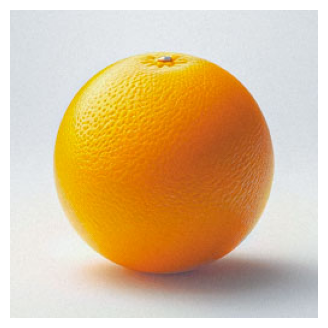

In [9]:
img_path5 = "../images/example5.jpg"
image_classification(img_path5)


	[PREDICTION]        [Prob]

	unripe mango        : 99.6%
	unripe banana       : 0.4%
	unripe tomato       : 0.0%

	Inference time: 13.3ms


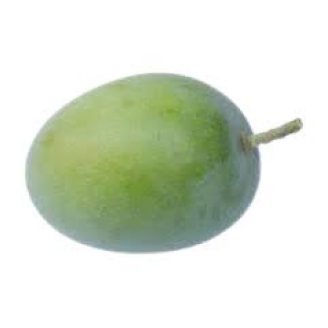

In [11]:
img_path7 = "../images/example7.jpg"
image_classification(img_path7)